In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math as mt
from tensorflow import keras
from tensorflow.keras import layers
import time
import wandb


physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
class linear_module_up(layers.Layer):
    
    def __init__(self):
        
        super().__init__()
        self.w = self.add_weight(
        name='w',
        shape=(2,2),
        initializer = 'random_normal',
        trainable = True
        )

    def call(self, x):
        
        L11 = tf.concat([[[1.,0.],[1.,1.]]], 0)
        L12 = self.w + tf.transpose(self.w)
        L21 = tf.concat([[[0.,0.],[0.,0.]]],0)
        L22 = tf.concat([[[1.,0.],[0.,1.]]],0)

        L = tf.concat([tf.concat([L11,L12], 1), tf.concat([L21,L22], 1)], 0)
        
        return tf.linalg.matvec(L,x)

class linear_module_low(layers.Layer):
    
    def __init__(self):
        
        super().__init__()
        self.w = self.add_weight(
        name='w',
        shape=(2,2),
        initializer = 'random_normal',
        trainable = True
        )

    def call(self, x):
        
        L11 = tf.concat([[[1.,0.],[1.,1.]]], 0)
        L12 = tf.concat([[[0.,0.],[0.,0.]]],0) 
        L21 = self.w + tf.transpose(self.w)
        L22 = tf.concat([[[1.,0.],[0.,1.]]],0)

        L = tf.concat([tf.concat([L11,L12], 1), tf.concat([L21,L22], 1)], 0)
        
        return tf.linalg.matvec(L,x)


class activation_module_up(layers.Layer):
    
    def __init__(self):
        
        super().__init__()
        self.w = self.add_weight(
        name='w',
        shape=(2,),
        initializer = 'random_normal',
        trainable = True
        )
        
    def tanh(self, x):
        
        return tf.where([True, True, False, False], tf.math.tanh(elem), elem)


    def call(self, x):        
        t = tf.concat([[[0.,0.,self.w[0], 0.]], [[0.,0.,0., self.w[1]]], [[0.,0.,0.,0.]], [[0.,0.,0.,0.]]], 0)
        
        return x + tf.linalg.matvec(t, tf.math.tanh(x))

class activation_module_low(layers.Layer):
    
    def __init__(self):
        
        super().__init__()
        self.w = self.add_weight(
        name='w',
        shape=(2,),
        initializer = 'random_normal',
        trainable = True
        )


    def call(self, x):
        t = tf.concat([[[0.,0.,0.,0.]], [[0.,0.,0.,0.]], [[self.w[0],0.,0.,0.]], [[0.,self.w[1],0.,0.]]],0)
        
        return x + tf.linalg.matvec(t, tf.math.tanh(x))

In [3]:
class SympNet(keras.Model):
    
    def __init__(self, N_layers, N_sub):
        
        super().__init__()
        
        
        self.Modules = []
        ind = [0]
        
        for i in range(N_layers):
            
            if i%2==0:
                self.Modules.append(activation_module_up())
                ind.append(ind[-1]+2)
                
            else:
                self.Modules.append(activation_module_low())
                ind.append(ind[-1]+2)
                
            for j in range(N_sub):
                
                if j%2==0:
                    self.Modules.append(linear_module_up())
                    ind.append(ind[-1]+3)

                else:
                    self.Modules.append(linear_module_low())
                    ind.append(ind[-1]+3)
        
        

    def call(self, input_tensor):
        
        boom = self.Modules[0](input_tensor)
        
        for i in range(1,len(self.Modules)):
            boom = self.Modules[i](boom)
    
        return boom

### Training Dataset

In [4]:
q0 = [1.5707963267948966, 1.566239991721592, 1.5525684142348404, 1.5297663397106285, 1.4977887927324212, 1.4565366561292123, 1.4058216571667934, 1.345315288418439, 1.2744749942705154, 1.192439405188996, 1.0978902204838283, 0.98893637750854, 0.863313832998702, 0.719979121128513, 0.5634707786673293, 0.40553835276492617, 0.2559015136168972, 0.11677369940421105, -0.01321349868486478, -0.135720559123984, -0.25173070244922685, -0.36143329122506257, -0.4643125934786468, -0.5592884560948824, -0.644880314285508, -0.7193799988602931, -0.7810102666568061, -0.8280354546553392, -0.8587967047942946, -0.8716537869529154, -0.8648494212646399, -0.8364294647245307, -0.7848184226611568, -0.7118531784049053, -0.6282566914142615, -0.5496432175219048, -0.48378730823347227, -0.43059859794700867, -0.38763940679069536, -0.3524414108302813, -0.32293721425987787, -0.29742786963772566, -0.27449044610855455, -0.2529046489556837, -0.23160512888980855, -0.20965387897265564, -0.18622676419662065, -0.16061022119489357, -0.13220512931034253, -0.10053601348320118, -0.06526290871104996, -0.026194059301420505, 0.016703494797548218, 0.06329829988706372, 0.11329605260636114, 0.1662483434154595, 0.22157045885723953, 0.2785609263020437, 0.33642631125851125, 0.3942999798562905]
q1 = [0.0, -0.30376435126781104, -0.6077495434555871, -0.9126254586263232, -1.219741879215434, -1.531417768449487, -1.8513689853576767, -2.1853459514332036, -2.5420424275635978, -2.934241774571085, -3.3795821838320097, -3.8972786273402993, -4.486024368096188, -5.046956533004935, -5.3142538255761975, -5.157279970634232, -4.8096328823693675, -4.474894873856334, -4.20054506421623, -3.972079185761887, -3.762924758053701, -3.547637153301479, -3.3048914147739805, -3.0185089869838126, -2.6780302031642123, -2.278679221184974, -1.8203439962909433, -1.305486653614162, -0.7362323461572511, -0.11121907409073595, 0.5758801678640377, 1.3289861424902814, 2.1057365044064102, 2.697742173636928, 2.7778228427218665, 2.421813243485241, 1.9726616801625438, 1.587834815789564, 1.2899652308515905, 1.0680124926761954, 0.9083173419683229, 0.8001701156374053, 0.7357452330142118, 0.7092122893314955, 0.7159596120077603, 0.7520336194179128, 0.8137407260256012, 0.8973632893951299, 0.9989569706873678, 1.1142134007270805, 1.2383988841867644, 1.3663768008960533, 1.4927292140820765, 1.6119521256211122, 1.718727775019843, 1.808171238165814, 1.8760532029964878, 1.918897567827292, 1.9339664516211645, 1.9191513478646356]
p0 = [0.0, 0.015010661596500906, 0.03016838349607194, 0.045849241601727375, 0.06268166688933882, 0.08155334769256958, 0.1036261438314411, 0.13036517471286946, 0.163590343668514, 0.205559669379517, 0.25908246937914287, 0.32757747885354793, 0.41464255598143124, 0.5215931221289993, 0.6410643032666817, 0.7546768209119165, 0.8465216690410882, 0.9115053436365511, 0.9501714651556946, 0.964227166866312, 0.9553048391110284, 0.924904554372447, 0.8745573812136203, 0.8059436672175694, 0.7209031441680881, 0.6213356178089464, 0.5090125952507778, 0.3853359171163647, 0.2510727118868576, 0.1060785506508933, -0.05097032245808686, -0.22270364368715354, -0.41229167844354564, -0.6193269498161159, -0.8320983557538961, -1.0322069201702464, -1.2110676594970053, -1.369735874550352, -1.511662327902453, -1.6398415956467602, -1.756414849050924, -1.8628213799574547, -1.9599887192601533, -2.0484763105169517, -2.128575170247076, -2.200377006101112, -2.263825181161412, -2.3187552214993925, -2.364930076806055, -2.402074913767808, -2.429911304591378, -2.448191102772614, -2.4567287879972306, -2.455426813912845, -2.44429361775101, -2.4234497495161733, -2.393123006575751, -2.3536363938681677, -2.305389463564221, -2.2488430195610345]
p1 = [0.5, 0.5014122198164906, 0.5111906410035314, 0.5376876256736828, 0.5893974749064902, 0.6751534377734025, 0.8044795691506748, 0.9881879083083701, 1.2392987580606556, 1.5742062960468985, 2.0131070034033582, 2.574312554731744, 3.241254718230227, 3.851520233340414, 4.000388645475294, 3.480353172035228, 2.618984378334507, 1.718652702955221, 0.8690673681519698, 0.0770189111114476, -0.6636138645097251, -1.3546350172552513, -1.9925133049403287, -2.5714568073703545, -3.087244424145427, -3.54061625555913, -3.9396551172397047, -4.301033141631248, -4.650493711146786, -5.023031241706978, -5.4617424865174335, -6.006704548681564, -6.636047860083942, -7.099996182944599, -6.968383419052819, -6.32721424951262, -5.607376674196277, -4.990916159914383, -4.487574403168241, -4.069493435935189, -3.7099432905399996, -3.38889931230865, -3.0919779687550126, -2.808775538309371, -2.5316288786200154, -2.254823032471658, -1.9741236304447236, -1.6865408931448582, -1.3902378804194453, -1.084519631778824, -0.7698408896427894, -0.44776986935769314, -0.12085470223367972, 0.20760836746941957, 0.5339318524324353, 0.8543906184453571, 1.1655832102649064, 1.4646334851920972, 1.7492574706100827, 2.017678639340289]

X = []
for i in zip(p0, p1, q0, q1):
    X.append([[i[0],i[1],i[2],i[3]]])

x_train = np.array(X[:len(X)-1])
y_train = np.array(X[1:])

### Model + training

In [17]:
model = SympNet(8, 5)

In [18]:
model.compile(
    #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    loss= tf.keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(),#, clipvalue = 0.001),
    metrics=["accuracy"],
)

In [ ]:
#wandb.init()

start_time = time.time()
history = model.fit(x_train, y_train, batch_size=59, epochs=50000, verbose=0)
print("running time : %s seconds" % (time.time() - start_time))

### Plot the loss

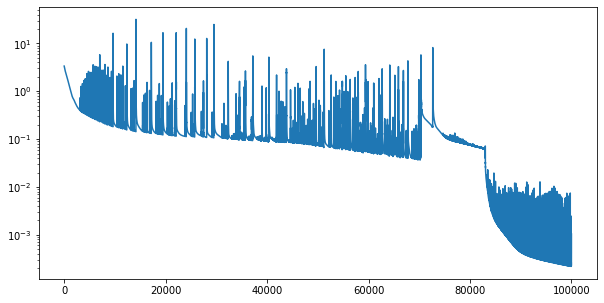

In [13]:
plt.figure(figsize = (10,5))
plt.plot(history.history["loss"])
plt.yscale("log")

### Plot the result

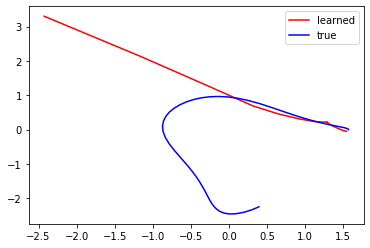

In [16]:
N_test = 15

p = [model(x_train[0][0])[0]]
pp = [model(x_train[0][0])[1]]

q = [model(x_train[0][0])[2]]
qq = [model(x_train[0][0])[3]]

run = [model(X[0][0])]

for i in range(N_test):
    run.append(model(run[-1]))
    p.append(run[-1][0])
    pp.append(run[-1][1])
    q.append(run[-1][2])
    qq.append(run[-1][3])


plt.plot(q, p, color = "r", label = "learned")
plt.plot(q0, p0, color = "b", label = "true")
plt.legend()
plt.show()